# Safaricom ReviewGuard - Multilingual Fake Review Detection System

## Objectives implemented in this notebook
1. To design a multilingual NLP framework capable of processing English, Swahili, and Sheng-like reviews from Safaricom and M-Pesa platforms.
2. To detect Sentiment–Rating Deception (rating contradicts sentiment).
3. To engineer text-based and behavioral features including TF-IDF representations, language indicators, duplicate detection, burst activity analysis, and similarity clustering.
4. To generate weak supervision labels for identifying suspicious or potentially fake reviews using rule-based heuristics.

In [ ]:
#imports
import os, re, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PATH = "/data/safaricom_reviews_multilingual.csv"
OUTPUT_DIR = "reviewguard_clean_outputs"

In [13]:
#Load raw data + inspect
df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())
df_raw.head()

Raw shape: (32000, 12)
Raw columns: ['app_name', 'app_id', 'reviewId', 'userName', 'review_text', 'rating', 'date', 'thumbs_up', 'version', 'lang_detected', 'is_code_mixed', 'is_sheng_like']


,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


Keep only necessary columns (drop the rest)

In [ ]:
#keep only these columns
keep_cols = [
    "app_name",      
    "review_text",    
    "rating",   
    "date",       
    "thumbs_up",    
    "version"       
]
#Keep only those that exist
keep_cols = [c for c in keep_cols if c in df_raw.columns]
df = df_raw[keep_cols].copy()
print("After column selection:", df.shape)
df.head()

After column selection: (32000, 6)


,app_name,review_text,rating,date,thumbs_up,version
0,M-PESA,best,5,2026-02-11 23:31:13,0,3.5.9
1,M-PESA,😔,1,2026-02-11 23:05:42,0,NaN
2,M-PESA,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9
3,M-PESA,Amazing,5,2026-02-11 21:38:06,0,3.5.9
4,M-PESA,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9


Clean types + remove empty rows + duplicates

In [ ]:
#Standardize required fields
df["review_text"] = df["review_text"].fillna("").astype(str)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

#Optional fields
if "thumbs_up" not in df.columns:
    df["thumbs_up"] = 0
df["thumbs_up"] = pd.to_numeric(df["thumbs_up"], errors="coerce").fillna(0).astype(int)

if "version" in df.columns:
    df["version"] = df["version"].astype(str)

#Drop rows with missing essentials
df = df.dropna(subset=["date", "rating"])
df = df[df["review_text"].str.strip() != ""]

#Clean ratings to 1–5 only
df = df[df["rating"].between(1, 5)].copy()
df["rating"] = df["rating"].astype(int)

#Remove exact duplicate review texts
df["review_text_norm"] = df["review_text"].str.lower().str.strip()
df = df.drop_duplicates(subset=["review_text_norm", "rating"], keep="first")

df = df.reset_index(drop=True)

print(" Cleaned shape:", df.shape)
df.head()

 Cleaned shape: (18153, 7)


,app_name,review_text,rating,date,thumbs_up,version,review_text_norm
0,M-PESA,best,5,2026-02-11 23:31:13,0,3.5.9,best
1,M-PESA,😔,1,2026-02-11 23:05:42,0,nan,😔
2,M-PESA,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,better option this vantine. 18yrs old day to d...
3,M-PESA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,amazing
4,M-PESA,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,its so easy to use at your comfort and you don...


**MULTILINGUAL NLP FRAMEWORK (English, Swahili, Sheng-like + code-mix)**

- Text preprocessing utilities (no emoji package)

In [ ]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
NON_WORD_RE = re.compile(r"[^a-zA-Z0-9\s']+")

EMOJI_PATTERN = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "\U00002700-\U000027BF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA70-\U0001FAFF"
    "]+",
    flags=re.UNICODE
)

def normalize_text(text: str) -> str:
    text = str(text).lower().strip()
    text = URL_RE.sub(" ", text)
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text)
    return text

def tokenize(text: str):
    text = normalize_text(text)
    text = NON_WORD_RE.sub(" ", text)
    return [t for t in text.split() if t]

def emoji_count(text: str) -> int:
    return len(EMOJI_PATTERN.findall(str(text)))

df["norm_text"] = df["review_text"].map(normalize_text)
df["tokens"] = df["review_text"].map(tokenize)
df["emoji_count"] = df["review_text"].map(emoji_count)
df["char_len"] = df["review_text"].str.len()
df["word_count"] = df["tokens"].map(len)
df[["review_text","emoji_count","word_count"]].head(5)

,review_text,emoji_count,word_count
0,best,0,1
1,😔,1,0
2,Better option this vantine. 18yrs old day to d...,0,10
3,Amazing,0,1
4,Its so easy to use at your comfort and you don...,0,19


- Language & Sheng indicators + code-mix score

In [ ]:
STOP_EN = {"the","a","an","and","or","to","of","in","on","for","with","is","are","was","were","it","this","that","i","you","we","my","your"}
STOP_SW = {"na","ya","wa","kwa","ni","si","hii","hiyo","kama","sana","katika","ndio","hapana","mimi","wewe","yeye","sisi","ninyi","wao","hapa","pale"}

SHENG = {
    "msee","manze","buda","rada","mambo","poa","freshi","fiti","noma","mbogi","vipi",
    "dem","wasee","morio","safi","mzae","mtoi","chill","kuuja","kuomoka", ""
}
def ratio_in_set(tokens, vocab):
    if not tokens:
        return 0.0
    return sum(t in vocab for t in tokens) / len(tokens)
def sheng_score(tokens):
    return ratio_in_set(tokens, SHENG)
def code_mix_score(tokens):
    if not tokens:
        return 0.0
    en = ratio_in_set(tokens, STOP_EN)
    sw = ratio_in_set(tokens, STOP_SW)
    return min(1.0, 4.0 * en * sw)
df["stop_en_ratio"] = df["tokens"].map(lambda t: ratio_in_set(t, STOP_EN))
df["stop_sw_ratio"] = df["tokens"].map(lambda t: ratio_in_set(t, STOP_SW))
df["sheng_score"] = df["tokens"].map(sheng_score)
df["code_mix_score"] = df["tokens"].map(code_mix_score)
df["is_sheng_like"] = (df["sheng_score"] >= 0.20).astype(int)
df["is_code_mixed"] = (df["code_mix_score"] >= 0.10).astype(int)
df[["review_text","sheng_score","code_mix_score","is_sheng_like","is_code_mixed"]].head(10)


,review_text,sheng_score,code_mix_score,is_sheng_like,is_code_mixed
0,best,0.0,0.0,0,0
1,😔,0.0,0.0,0,0
2,Better option this vantine. 18yrs old day to d...,0.0,0.0,0,0
3,Amazing,0.0,0.0,0,0
4,Its so easy to use at your comfort and you don...,0.0,0.0,0,0
5,good 👍,0.0,0.0,0,0
6,😊👍,0.0,0.0,0,0
7,very helpful and reduces a lot of work in term...,0.0,0.0,0,0
8,its good and nice app,0.0,0.0,0,0
9,Great,0.0,0.0,0,0


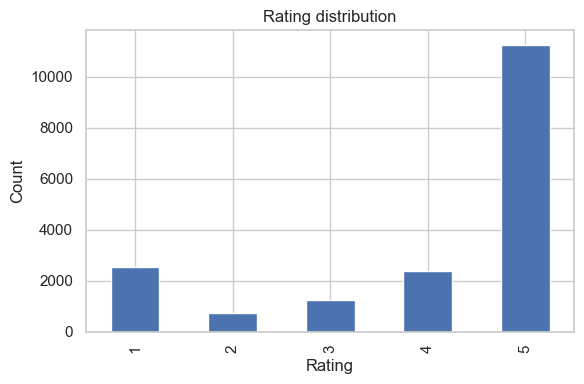

In [ ]:
#EDA plot 1 - rating distribution
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = df['rating'].value_counts().sort_index().plot(kind='bar', color='C0')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Rating distribution')
plt.tight_layout()
plt.show()

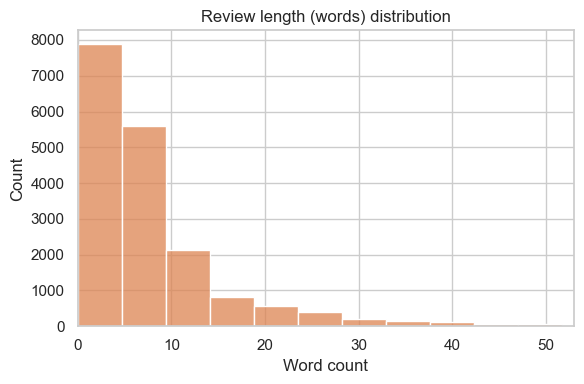

In [ ]:
#EDA plot 2-Review length(word count)distribution
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=30, kde=False, color='C1')
plt.xlabel('Word count')
plt.title('Review length (words) distribution')
#zoom x-axis to 99th percentile to avoid extreme tails
plt.xlim(0, min(100, int(df['word_count'].quantile(0.99))))
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13032\2757449643.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emoji_count', data=subset, palette='Blues')


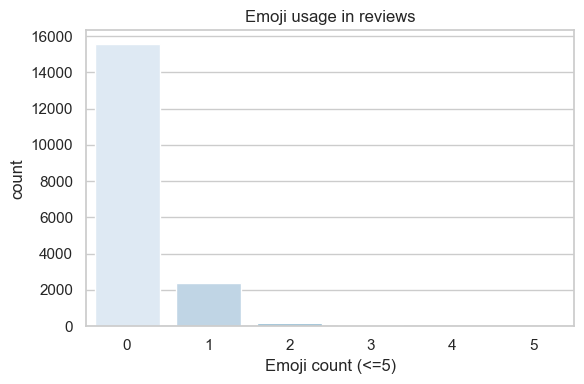

In [ ]:
#EDA plot3Emoji usage (showing counts <=5)
plt.figure(figsize=(6,4))
subset = df[df['emoji_count'] <= 5].copy()
if len(subset):
    sns.countplot(x='emoji_count', data=subset, palette='Blues')
    plt.xlabel('Emoji count (<=5)')
    plt.title('Emoji usage in reviews')
    plt.tight_layout()
    plt.show()
else:
    print('No emoji data to plot')

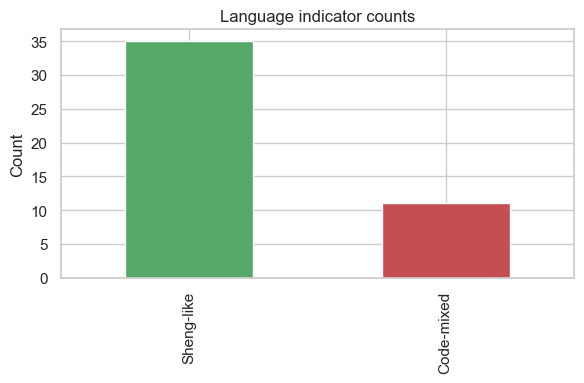

In [ ]:
#EDA plot 4-Language indicators (Sheng-like vs Code-mixed)
plt.figure(figsize=(6,4))
counts = df[['is_sheng_like','is_code_mixed']].sum()
counts.index = ['Sheng-like','Code-mixed']
counts.plot(kind='bar', color=['C2','C3'])
plt.ylabel('Count')
plt.title('Language indicator counts')
plt.tight_layout()
plt.show()

**Sentiment–Rating Deception (Objective 2)**
- Simple sentiment lexicon + deception flag

In [ ]:
POS_EN = {"good","great","excellent","best","nice","amazing","awesome","love","perfect","works","helpful"}
NEG_EN = {"bad","worst","terrible","awful","hate","poor","bug","bugs","crash","crashes","error","fails","slow","useless"}

POS_SW = {"nzuri","poa","safi","vizuri","bora","napenda","imekaa"}
NEG_SW = {"mbaya","mbovu","inakataa","kosa","hitilafu","pole","haifanyi","inakwama","taratibu"}

def simple_sentiment(tokens):
    tokset = set(tokens)
    pos = len(tokset & POS_EN) + len(tokset & POS_SW)
    neg = len(tokset & NEG_EN) + len(tokset & NEG_SW)
    if pos > neg and pos > 0:
        return 1
    if neg > pos and neg > 0:
        return -1
    return 0

def sentiment_rating_deception(tokens, rating):
    sent = simple_sentiment(tokens)
    #Deception / contradiction examples
    #rating 5 but negative sentiment; rating 1 but positive sentiment
    if rating == 5 and sent == -1:
        return 1
    if rating == 1 and sent == 1:
        return 1
    return 0

df["sentiment"] = df["tokens"].map(simple_sentiment)
df["is_sentiment_rating_deception"] = [
    sentiment_rating_deception(t, r) for t, r in zip(df["tokens"], df["rating"])
]

df["is_sentiment_rating_deception"].value_counts()


is_sentiment_rating_deception
0    17792
1      361
Name: count, dtype: int64

**Feature Engineering (Objective 3: TF-IDF + behavioral signals)**
- Duplicate detection (exact repeats)

In [23]:
counts = df["norm_text"].value_counts()
df["is_exact_duplicate"] = df["norm_text"].map(lambda x: 1 if counts.get(x, 0) >= 5 else 0)
df["is_exact_duplicate"].value_counts()

is_exact_duplicate
0    18038
1      115
Name: count, dtype: int64

- Burst activity (per app per day)

In [ ]:
df["date_day"] = df["date"].dt.date

if "app_name" in df.columns:
    grp = df.groupby(["app_name","date_day"]).size()
    burst_threshold = np.quantile(grp.values, 0.99) if len(grp) else 0
    burst_map = grp.to_dict()
    df["is_burst_day"] = df.apply(
        lambda r: 1 if burst_map.get((r["app_name"], r["date_day"]), 0) >= burst_threshold else 0,
        axis=1
    )
else:
    grp = df.groupby(["date_day"]).size()
    burst_threshold = np.quantile(grp.values, 0.99) if len(grp) else 0
    burst_map = grp.to_dict()
    df["is_burst_day"] = df["date_day"].map(lambda d: 1 if burst_map.get(d,0) >= burst_threshold else 0)
df["is_burst_day"].value_counts()

is_burst_day
0    17184
1      969
Name: count, dtype: int64

- Similarity clustering / near-duplicates (TF-IDF + nearest neighbors)

In [ ]:
vec = TfidfVectorizer(min_df=2, ngram_range=(1,2), max_features=50000)
X = vec.fit_transform(df["norm_text"])

nn = NearestNeighbors(n_neighbors=6, metric="cosine", algorithm="brute")
nn.fit(X)
dist, _ = nn.kneighbors(X)

sim = 1 - dist
#near-duplicate if >=2 neighbors have similarity >= 0.92
df["is_near_duplicate"] = ((sim >= 0.92).sum(axis=1) >= 2).astype(int)

df["is_near_duplicate"].value_counts()

is_near_duplicate
0    14512
1     3641
Name: count, dtype: int64

**Weak Supervision Labels (Objective 4)**
- Weak score rules + final label

In [ ]:
spam_re = re.compile(r"(buy now|download now|visit|click|offer|free money|promo|mpesa agent)", re.IGNORECASE)
many_punct_re = re.compile(r"([!?.])\1{3,}")

df["has_spam_pattern"] = df["review_text"].apply(
    lambda x: 1 if (spam_re.search(str(x)) or many_punct_re.search(str(x))) else 0
)

def weak_suspicion_score(row):
    score = 0

    #High-confidence suspicious signals
    if row["has_spam_pattern"] == 1:
        score += 3

    if row["is_sentiment_rating_deception"] == 1:
        score += 2
            
    #Coordinated behavior signals
    if row["is_near_duplicate"] == 1:
        score += 2

    if row["is_exact_duplicate"] == 1:
        score += 1.5
    
    if row["is_burst_day"] == 1:
        score += 1
   #Short generic extreme rating
    if row["word_count"] <= 2 and row["rating"] in [1,5]:
        score += 1

    return score
df["weak_suspicion_score"] = df.apply(weak_suspicion_score, axis=1)
LABEL_THRESH = 2.0 
df["is_suspicious_review"] = (df["weak_suspicion_score"] >= LABEL_THRESH).astype(int)

print("Suspicious rate:", round(df["is_suspicious_review"].mean(), 4))
df["weak_suspicion_score"].describe()


Suspicious rate: 0.2405


count    18153.000000
mean         0.724040
std          1.150989
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.500000
Name: weak_suspicion_score, dtype: float64

- Review examples (sanity check)

In [27]:
df.sort_values("weak_suspicion_score", ascending=False)[
    ["review_text","rating","weak_suspicion_score",
     "is_sentiment_rating_deception","is_exact_duplicate","is_near_duplicate","is_burst_day","has_spam_pattern"]
].head(20)

,review_text,rating,weak_suspicion_score,is_sentiment_rating_deception,is_exact_duplicate,is_near_duplicate,is_burst_day,has_spam_pattern
304,Great app,1,7.5,1,1,1,1,0
11142,work perfectly....,5,7.0,0,0,1,1,1
1729,excellent,1,6.5,1,1,1,0,0
16645,so good,1,6.5,1,1,1,0,0
1511,best,1,6.5,1,1,1,0,0
1418,it's good,1,6.5,1,1,1,0,0
7670,awesome,1,6.5,1,1,1,0,0
3334,great,1,6.5,1,1,1,0,0
5394,good 👍,1,6.5,1,1,1,0,0
2816,Perfect,1,6.5,1,1,1,0,0


In [28]:
#Save cleaned + labeled dataset
clean_labeled_path = os.path.join(OUTPUT_DIR, "reviews_clean_weak_labeled.csv")
df.to_csv(clean_labeled_path, index=False)
print("Saved cleaned + weak-labeled dataset:", clean_labeled_path)

Saved cleaned + weak-labeled dataset: reviewguard_clean_outputs\reviews_clean_weak_labeled.csv


**BASELINE MODEL (TF-IDF + Logistic Regression) THIS IS THE MODEL PART**
- Time-based split

In [29]:
df_model = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
split = int(len(df_model) * 0.8)

train_df = df_model.iloc[:split].copy()
test_df  = df_model.iloc[split:].copy()

y_train = train_df["is_suspicious_review"].astype(int).values
y_test  = test_df["is_suspicious_review"].astype(int).values

print("Train:", train_df.shape, "Test:", test_df.shape)

Train: (14522, 27) Test: (3631, 27)


- Model pipeline (TF-IDF text + engineered numeric features)

In [30]:
numeric_features = [
    "rating", "thumbs_up", "char_len", "word_count", "emoji_count",
    "stop_en_ratio", "stop_sw_ratio", "sheng_score", "code_mix_score",
    "is_exact_duplicate", "is_near_duplicate", "is_burst_day",
    "is_sentiment_rating_deception", "has_spam_pattern",
    "is_sheng_like", "is_code_mixed"
]

text_tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), max_features=80000, sublinear_tf=True)

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("text", text_tfidf, "review_text"),
        ("num",  num_pipe,  numeric_features)
    ],
    remainder="drop"
)

clf = LogisticRegression(max_iter=2000, class_weight="balanced")

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

model

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**train the model**


In [31]:
model.fit(train_df, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


- model evaluation

In [ ]:
proba = model.predict_proba(test_df)[:, 1]
pred = (proba >= 0.5).astype(int)
print(classification_report(y_test, pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))

              precision    recall  f1-score   support

           0     0.9969    0.9961    0.9965      2557
           1     0.9907    0.9926    0.9916      1074

    accuracy                         0.9950      3631
   macro avg     0.9938    0.9943    0.9941      3631
weighted avg     0.9950    0.9950    0.9950      3631

Confusion Matrix:
 [[2547   10]
 [   8 1066]]
ROC-AUC: 0.9998


- saving the model

In [ ]:
MODEL_PATH = os.path.join(OUTPUT_DIR, "reviewguard_baseline.pkl")
with open(MODEL_PATH, "wb") as f:
    pickle.dump(model, f)
META_PATH = os.path.join(OUTPUT_DIR, "metadata.json")
meta = {
    "label_threshold": LABEL_THRESH,
    "prediction_threshold": 0.5,
    "numeric_features": numeric_features,
    "model_path": MODEL_PATH,
    "clean_labeled_data": clean_labeled_path
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)
print("Saved model to ", MODEL_PATH)
print("Saved metadata to ", META_PATH)


Saved model to  reviewguard_clean_outputs\reviewguard_baseline.pkl
Saved metadata to  reviewguard_clean_outputs\metadata.json


Text(0, 0.5, 'TPR')

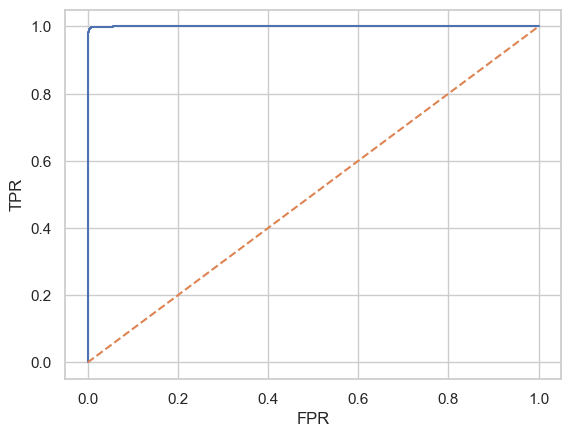

In [47]:
#model ROC Curve
from sklearn.metrics import roc_curve, auc
fpr,tpr,_ = roc_curve(y_test, proba)
plt.plot(fpr,tpr,label=f'AUC={auc(fpr,tpr):.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')

Text(0, 0.5, 'Precision')

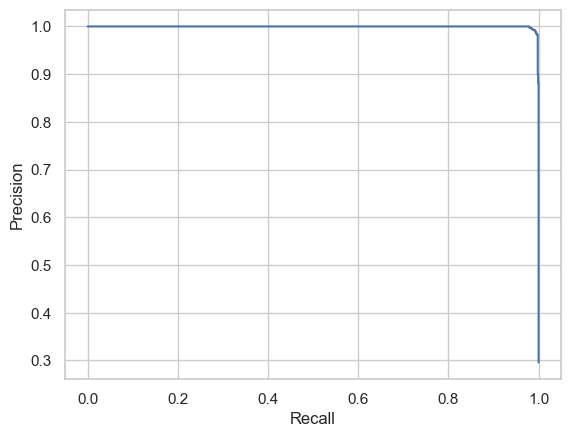

In [ ]:
#Precision–Recall Curve
from sklearn.metrics import precision_recall_curve
p, r, _ = precision_recall_curve(y_test, proba)
plt.plot(r,p)
plt.xlabel('Recall')
plt.ylabel('Precision')

<Axes: >

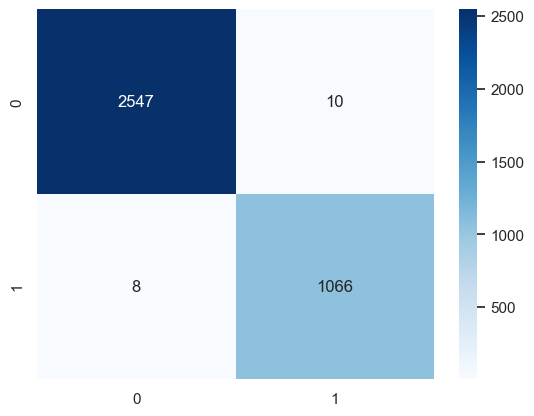

In [49]:
#Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Text(0.5, 1.0, 'Probability distribution')

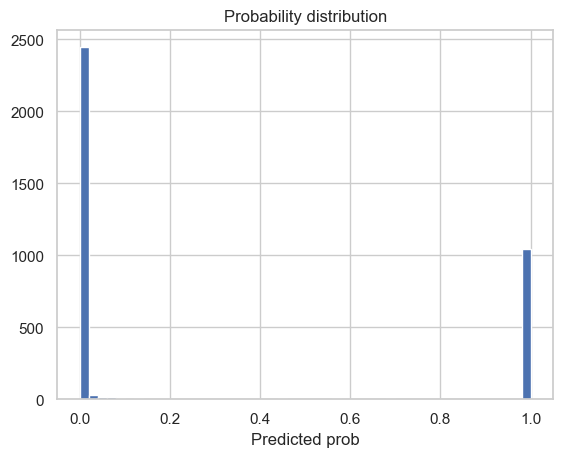

In [50]:
#Predicted-Probability Distribution
plt.hist(proba, bins=50)
plt.xlabel('Predicted prob')
plt.title('Probability distribution')

**testing the model**

- real text test

In [51]:
def predict_one(review_text, rating=5, thumbs_up=0):
    row_tokens = tokenize(review_text)
    row = pd.DataFrame([{
        "review_text": review_text,
        "rating": rating,
        "thumbs_up": thumbs_up,
        "char_len": len(str(review_text)),
        "word_count": len(row_tokens),
        "emoji_count": emoji_count(review_text),
        "stop_en_ratio": ratio_in_set(row_tokens, STOP_EN),
        "stop_sw_ratio": ratio_in_set(row_tokens, STOP_SW),
        "sheng_score": sheng_score(row_tokens),
        "code_mix_score": code_mix_score(row_tokens),
        "is_exact_duplicate": 0,
        "is_near_duplicate": 0,
        "is_burst_day": 0,
        "is_sentiment_rating_deception": sentiment_rating_deception(row_tokens, rating),
        "has_spam_pattern": 1 if (spam_re.search(str(review_text)) or many_punct_re.search(str(review_text))) else 0,
        "is_sheng_like": 1 if sheng_score(row_tokens) >= 0.20 else 0,
        "is_code_mixed": 1 if code_mix_score(row_tokens) >= 0.10 else 0,
    }])
    p = model.predict_proba(row)[0, 1]
    label = "Suspicious" if p >= 0.5 else "Genuine"
    return p, label
p, label = predict_one("Inakwama sana tangu update, haifanyi.", rating=1)
print("Probability:", round(p, 3), "| Prediction:", label)

Probability: 0.0 | Prediction: Genuine


In [52]:
#spam-like
p, label = predict_one("Best app ever!!! best app ever!!! best app ever!!!", rating=5)
print(round(p,3), label)

0.0 Genuine


In [53]:
#Rating-Sentiment deception
p, label = predict_one("Worst app ever, crashes all the time", rating=4)
print(round(p,3), label)

0.0 Genuine


In [54]:
#promotional spam
p, label = predict_one("Hurry up and get offer limited", rating=5)
print(round(p,3), label)

1.0 Suspicious


In [55]:
df.groupby("has_spam_pattern")["is_suspicious_review"].mean()


has_spam_pattern
0    0.222335
1    1.000000
Name: is_suspicious_review, dtype: float64